In [2]:
import numpy as np
import xarray as xr
from u import *
from scipy.io import savemat
import xesmf as xe
import os
import xbpch
from tqdm import tqdm
import warnings; warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Get sensitivity

In [3]:
base_path = Path('/net/d07/data/rlan/from_d05/gcadj_std/output')
base_name = '/net/d07/data/rlan/from_d05/gcadj_std/output/'

In [3]:
def get_ymd(path):
    yrmndt = path.split('.')[2]
    year = yrmndt[:4]
    month = yrmndt[4:6]
    date = yrmndt[6:]
    hour = path.split('.')[3]
    return year, month, date, hour

years = ['2007','2009','2012']
for year in years:
    paths = os.listdir(base_path/f'{year}_whole'/'diagadj')
    paths = [x for x in paths if x.startswith('gctm')]
    if year == '2009':
        for path in sorted(paths)[531:532]:
            year, month, date, hour = get_ymd(path)
            print(year, month, date, hour)
    else:
        for path in sorted(paths)[744:745]:
            year, month, date, hour = get_ymd(path)
            print(year, month, date, hour)

    for path in sorted(paths)[-720:-719]:
        year, month, date, hour = get_ymd(path)
        print(year, month, date, hour)

2007 01 01 0000
2008 01 01 0000
2009 01 01 0000
2010 01 01 0000
2012 01 01 0000
2013 01 01 0000


In [24]:
BCs = []
OCs = []
sens_path = Path('/home/rlan/sensitivity/')
target = ['BCPI', 'BCPO', 'OCPI', 'OCPO']
for year in years:
    paths = os.listdir(base_path/f'{year}_whole'/'diagadj')
    paths = [x for x in paths if x.startswith('gctm')]
    for path in tqdm(sorted(paths)[531:-720]):
        fn_path = base_name + f'{year}_whole' + '/diagadj/' + path
        tracer = os.path.join(base_name + f'{year}_whole','tracerinfo.dat')
        diag = os.path.join(base_name + f'{year}_whole','diaginfo.dat')
        ds = xbpch.open_bpchdataset(fn_path,tracerinfo_file=tracer,diaginfo_file=diag, fields=target)
        BC = ds.isel(lev=0).IJ_ADJ_S_BCPI + ds.isel(lev=0).IJ_ADJ_S_BCPO
        BCs.append(np.array(BC))
        OC = ds.isel(lev=0).IJ_ADJ_S_OCPI + ds.isel(lev=0).IJ_ADJ_S_OCPO
        OCs.append(np.array(OC))
    sens_BC = np.array(BCs) 
    sens_OC = np.array(OCs)

    sens = sens_BC + 2.1 * sens_OC
    sens = xr.DataArray(sens)
    sens.to_netcdf(sensitivity/f'sens_{year}.nc')

100%|██████████| 8760/8760 [2:13:16<00:00,  1.10it/s]  


# Regrid sensitivity and agrregate by 24 hour

In [4]:
target = ['BCPI', 'BCPO', 'OCPI', 'OCPO']
base_name = '/net/d07/data/rlan/from_d05/gcadj_std/output/'
fn_path = base_name + f'{2007}_whole' + '/diagadj/' + 'gctm.adj.20080130.2300'
tracer = os.path.join(base_name + f'{2007}_whole','tracerinfo.dat')
diag = os.path.join(base_name + f'{2007}_whole','diaginfo.dat')
ds = xbpch.open_bpchdataset(fn_path,tracerinfo_file=tracer,diaginfo_file=diag, fields=target)

In [5]:
ds.close()

In [6]:
ds_in = ds
nested_grid_with_bounds = {'lon': np.arange(ds_in.lon[0], ds_in.lon[-1], 0.1),
                           'lat': np.arange(ds_in.lat[0], ds_in.lat[-1], 0.1),
                           'lon_b': np.arange(ds_in.lon[0]-0.1/2, ds_in.lon[-1]+0.1/2, 0.1),
                           'lat_b': np.arange(ds_in.lat[0]-0.1/2, ds_in.lat[-1]+0.1/2, 0.1),
                          }

global_grid_with_bounds = {'lon': ds_in['lon'].values,
                           'lat': ds_in['lat'].values,
                           'lon_b': np.arange(ds_in.lon[0]-2/3/2, ds_in.lon[-1]+2/3/2, 2/3),
                           'lat_b': np.arange(ds_in.lat[0]-0.5/2, ds_in.lat[-1]+0.5, 0.5), 
                          }

regridder_conserve = xe.Regridder(global_grid_with_bounds, nested_grid_with_bounds, method='conservative')

In [98]:
nested_grid_with_bounds['lat'].shape

(660,)

# 3d

In [45]:
factor = (660*801)/(121*133)
sens_path = Path('/home/rlan/sensitivity/')
for year in years:
    ds = xr.open_dataset(sens_path / f'sens_{year}.nc')
    ds_in = ds['__xarray_dataarray_variable__']
    days = int(ds_in.shape[0] / 24)
    ds_out = []
    for day in range(0,days):
        ds_temp = []
        for hour in range(0,24):
            ds_temp.append(ds_in.isel(dim_0= day*24 + hour))
        ds_temp = np.array(ds_temp).mean(axis=0) / factor
        ds_temp = xr.DataArray(ds_temp)
        ds_out.append(regridder_conserve(ds_temp.T))
    ds_out = xr.DataArray(ds_out)
    ds_out.to_netcdf(sens_path / f'gridded_sens_{year}.nc')


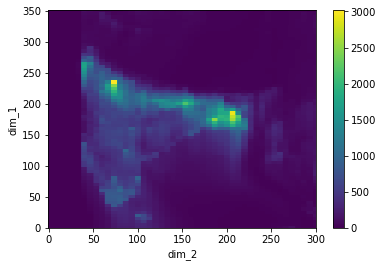

In [79]:
ds_out[dict(dim_0=1,dim_2=slice(0,301),dim_1=slice(160,511))].plot()

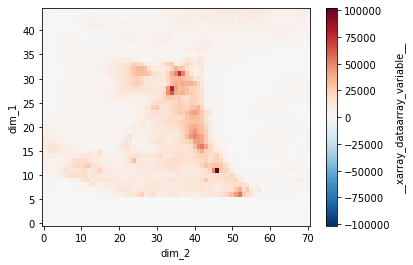

In [74]:
ds_in[dict(dim_0=1,dim_1=slice(0,45),dim_2=slice(33,104))].plot()

# 4d

In [13]:
factor = (660*801)/(121*133)
sens_path = Path('/home/rlan/sensitivity/')
for year in [2007, 2009, 2012]:
    ds = xr.open_dataset(sens_path / f'sens_{year}.nc')
    ds_in = ds['__xarray_dataarray_variable__']
    days = int(ds_in.shape[0] / 24)
    ds_out = []
    for day in range(91,152):
        ds_day = []
        for hour in range(0,24):
            temp = regridder_conserve(ds_in.isel(dim_0=day*24 + hour).T)
            s = temp.sel(lat=slice(5.05, 40.1), lon=slice(70, 100.1)) 
            ds_day.append(s)
        ds_day = np.array(ds_day) / factor
        ds_day = xr.DataArray(ds_day)
        ds_out.append(ds_day)
    ds_out = xr.DataArray(ds_out)
    ds_out.to_netcdf(sens_path / f'gridded_sens_{year}_4d_pre_monsoon.nc')
    ds.close()


In [12]:
ds_out.shape

(61, 24, 351, 301)

In [14]:
factor = (660*801)/(121*133)
sens_path = Path('/home/rlan/sensitivity/')
for year in [2007, 2009, 2012]:
    ds = xr.open_dataset(sens_path / f'sens_{year}.nc')
    ds_in = ds['__xarray_dataarray_variable__']
    days = int(ds_in.shape[0] / 24)
    ds_out = []
    for day in range(274,335):
        ds_day = []
        for hour in range(0,24):
            temp = regridder_conserve(ds_in.isel(dim_0=day*24 + hour).T)
            s = temp.sel(lat=slice(5.05, 40.1), lon=slice(70, 100.1)) 
            ds_day.append(s)
        ds_day = np.array(ds_day) / factor
        ds_day = xr.DataArray(ds_day)
        ds_out.append(ds_day)
    ds_out = xr.DataArray(ds_out)
    ds_out.to_netcdf(sens_path / f'gridded_sens_{year}_4d_post_monsoon.nc')
    ds.close()


In [18]:
for year in [2007, 2009, 2012]:
    ds = xr.open_dataset(sens_path / f'gridded_sens_{year}_4d_post_monsoon.nc')
    sens = ds['__xarray_dataarray_variable__']
    sens = np.array(sens)
    savemat(sens_path / f'gridded_sens_{year}_4d_post_monsoon.mat', mdict={'sens_4d': sens})

In [19]:
for year in [2007, 2009, 2012]:
    ds = xr.open_dataset(sens_path / f'gridded_sens_{year}_4d_pre_monsoon.nc')
    sens = ds['__xarray_dataarray_variable__']
    sens = np.array(sens)
    savemat(sens_path / f'gridded_sens_{year}_4d_pre_monsoon.mat', mdict={'sens_4d': sens})

In [21]:
sens.shape

(61, 24, 351, 301)